In [2]:
!nvidia-smi

Sat Sep 13 12:12:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import drive
import zipfile
import os
drive.mount('/content/drive')
zip_path = "/content/drive/MyDrive/brain_tumer/brain-tumor-dataset.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")
os.listdir("dataset")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['brain-tumor-dataset']

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [6]:
# Data Preprocessing
train_dir = "/content/dataset/brain-tumor-dataset/Training"
val_dir   = "/content/dataset/brain-tumor-dataset/Validation"
test_dir  = "/content/dataset/brain-tumor-dataset/Testing"

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1055 images belonging to 4 classes.
Found 256 images belonging to 4 classes.


In [7]:
# Model (Densenet121) and useing Regularization L2
from tensorflow.keras.regularizers import l2
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(4, activation="softmax", kernel_regularizer=l2(0.001))(x)

model = Model(inputs=base_model.input, outputs=output)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'))
    fp = tf.reduce_sum(tf.cast((1-y_true) * y_pred, 'float'))
    fn = tf.reduce_sum(tf.cast(y_true * (1-y_pred), 'float'))

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    return 2*((precision*recall)/(precision+recall+tf.keras.backend.epsilon()))
class CustomLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.epoch_start
        print(f"\nEpoch {epoch+1}/{self.params['epochs']} | Time: {elapsed:.2f}s")
        print(f"Train Loss: {logs['loss']:.4f} | "
              f"Acc: {logs['accuracy']:.4f} | "
              f"Precision: {logs['precision']:.4f} | "
              f"Recall: {logs['recall']:.4f} | "
              f"F1: {logs['f1_score']:.4f}")
        print(f"Val   Loss: {logs['val_loss']:.4f} | "
              f"Acc: {logs['val_accuracy']:.4f} | "
              f"Precision: {logs['val_precision']:.4f} | "
              f"Recall: {logs['val_recall']:.4f} | "
              f"F1: {logs['val_f1_score']:.4f}")
        print("-"*90)
model.compile(
    optimizer=Adam(learning_rate=1e-4),#(adam optimizer)
    loss="categorical_crossentropy",# more categerical_crossentropy(class)
    metrics=["accuracy",
             Precision(name="precision"),
             Recall(name="recall"),
             f1_score]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 263,428 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [9]:
# EarlyStopping Callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
# Training Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[CustomLogger(), early_stopping]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.4944 - f1_score: 0.4495 - loss: 1.6425 - precision: 0.5552 - recall: 0.3824
Epoch 1/50 | Time: 154.90s
Train Loss: 1.3168 | Acc: 0.6182 | Precision: 0.6902 | Recall: 0.5075 | F1: 0.5788
Val   Loss: 0.9459 | Acc: 0.7829 | Precision: 0.8526 | Recall: 0.7071 | F1: 0.7721
------------------------------------------------------------------------------------------
179/179 ━━━━━━━━━━━━━━━━━━━━ 155s 687ms/step - accuracy: 0.4950 - f1_score: 0.4502 - loss: 1.6407 - precision: 0.5560 - recall: 0.3831 - val_accuracy: 0.7829 - val_f1_score: 0.7721 - val_loss: 0.9459 - val_precision: 0.8526 - val_recall: 0.7071
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.7795 - f1_score: 0.7679 - loss: 0.8887 - precision: 0.8317 - recall: 0.7151
Epoch 2/50 | Time: 82.47s
Train Loss: 0.8586 | Acc: 0.7868 | Precision: 0.8363 | Recall: 0.7281 | F1: 0.7772
Val   Loss: 0.8329 | Acc: 0.7896 | Precision: 0.8337 | Recall: 0.7507 | F1

In [10]:
model.save("brain_tumor_densenet_original_updated.h5")
print("Model saved as brain_tumor_densenet_original_updated.h5")

Model saved as brain_tumor_densenet_original_updated.h5


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


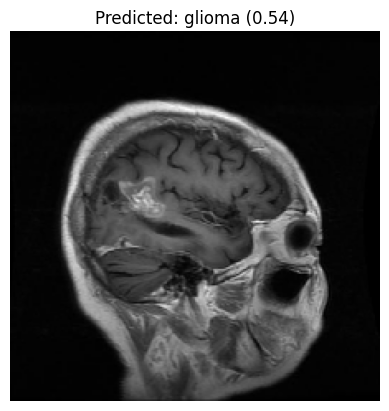

Predicted Class: glioma (Confidence: 0.54)


In [ ]:
#glioma Test
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
model = load_model("/content/brain_tumor_densenet_original_updated.h5",
                   custom_objects={"f1_score": f1_score})
class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)
img_path = "/content/Te-gl_0168.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
pred = model.predict(img_array)
class_id = np.argmax(pred)
confidence = np.max(pred)

plt.imshow(image.array_to_img(img_array[0]))
plt.axis("off")
plt.title(f"Predicted: {class_names[class_id]} ({confidence:.2f})")
plt.show()
print(f"Predicted Class: {class_names[class_id]} (Confidence: {confidence:.2f})")


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


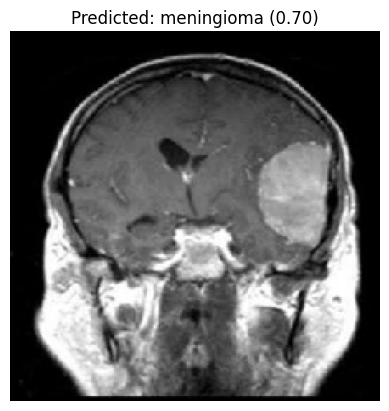

Predicted Class: meningioma (Confidence: 0.70)


In [ ]:
#meningioma Test
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
model = load_model("/content/brain_tumor_densenet_original_updated.h5",
                   custom_objects={"f1_score": f1_score})
class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)
img_path = "/content/Te-me_0016.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
pred = model.predict(img_array)
class_id = np.argmax(pred)
confidence = np.max(pred)

plt.imshow(image.array_to_img(img_array[0]))
plt.axis("off")
plt.title(f"Predicted: {class_names[class_id]} ({confidence:.2f})")
plt.show()
print(f"Predicted Class: {class_names[class_id]} (Confidence: {confidence:.2f})")


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


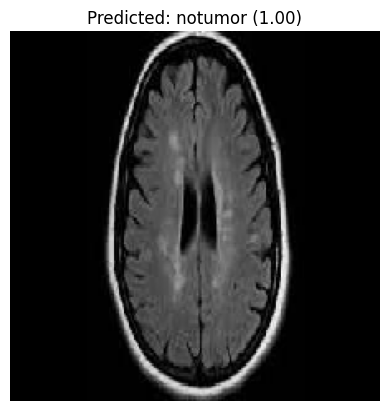

Predicted Class: notumor (Confidence: 1.00)


In [ ]:
#pituitary Test
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
model = load_model("/content/brain_tumor_densenet_original_updated.h5",
                   custom_objects={"f1_score": f1_score})
class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)
img_path = "/content/Te-no_0308.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
pred = model.predict(img_array)
class_id = np.argmax(pred)
confidence = np.max(pred)

plt.imshow(image.array_to_img(img_array[0]))
plt.axis("off")
plt.title(f"Predicted: {class_names[class_id]} ({confidence:.2f})")
plt.show()
print(f"Predicted Class: {class_names[class_id]} (Confidence: {confidence:.2f})")


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


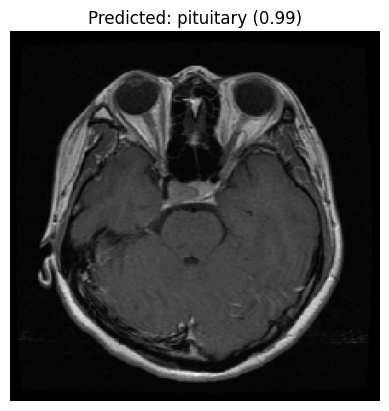

Predicted Class: pituitary (Confidence: 0.99)


In [ ]:
#pituitary Test
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
model = load_model("/content/brain_tumor_densenet_original_updated.h5",
                   custom_objects={"f1_score": f1_score})
class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)
img_path = "/content/Te-pi_0146.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
pred = model.predict(img_array)
class_id = np.argmax(pred)
confidence = np.max(pred)

plt.imshow(image.array_to_img(img_array[0]))
plt.axis("off")
plt.title(f"Predicted: {class_names[class_id]} ({confidence:.2f})")
plt.show()
print(f"Predicted Class: {class_names[class_id]} (Confidence: {confidence:.2f})")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step


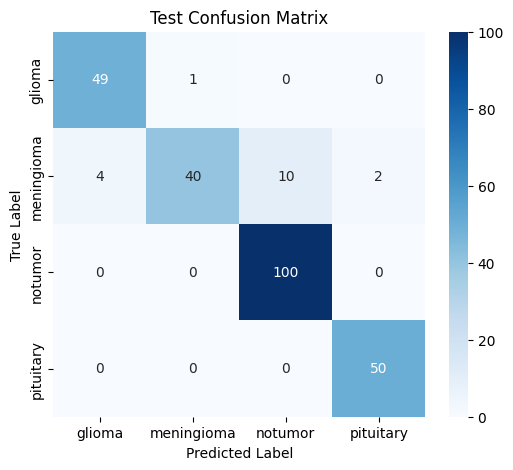

In [24]:
# Test Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(generator, preds, title="Confusion Matrix"):
    y_pred = np.argmax(preds, axis=1)
    y_true = generator.classes
    class_labels = list(generator.class_indices.keys())
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{title} Confusion Matrix")
    plt.show()
preds_test = model.predict(test_generator)
plot_confusion_matrix(test_generator, preds_test, "Test")

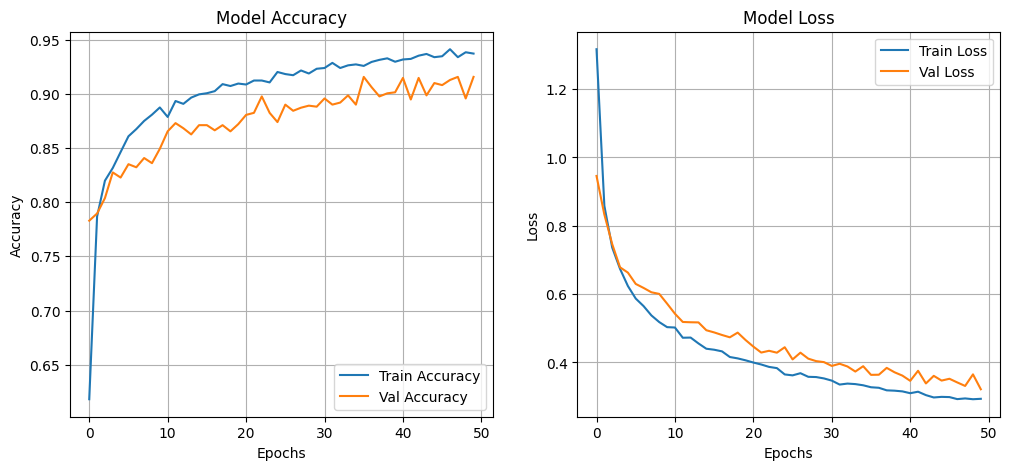

In [26]:
#Model Accuracy && Loss
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_training_history(history)

